## Header

### Imports

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave
import numpy as np
import cv2
import h5py
import tifffile
import tqdm
import sys
import time
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as fn
import numpy as np
import math
from scipy.optimize import curve_fit

device = torch.device('cuda:0')


### Funcs

In [2]:


def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)


def loadImage(imageName, expectedShape=None) :
    if not imageName:
        return None
    #imdata = imread(imageName).astype(np.float32)
    imdata = tifffile.imread(imageName).astype(np.float32)
    if len(imdata.shape) == 3 :
        imdata = np.mean(imdata[:,:,0:3], 2)
    if not expectedShape is None  and  imdata.shape != expectedShape :
        raise Exception(f"Dimensions of the input image \"{imageName}\" {imdata.shape} "
                        f"do not match expected shape {expectedShape}.")
    return imdata



def plotData(dataY, rangeY=None, dataYR=None, rangeYR=None,
             dataX=None, rangeX=None, rangeP=None,
             figsize=(16,8), saveTo=None, show=True):

    if type(dataY) is np.ndarray :
        plotData((dataY,), rangeY=rangeY, dataYR=dataYR, rangeYR=rangeYR,
             dataX=dataX, rangeX=rangeX, rangeP=rangeP,
             figsize=figsize, saveTo=saveTo, show=show)
        return
    if type(dataYR) is np.ndarray :
        plotData(dataY, rangeY=rangeY, dataYR=(dataYR,), rangeYR=rangeYR,
             dataX=dataX, rangeX=rangeX, rangeP=rangeP,
             figsize=figsize, saveTo=saveTo, show=show)
        return
    if type(dataY) is not tuple and type(dataY) is not list:
        eprint(f"Unknown data type to plot: {type(dataY)}.")
        return
    if type(dataYR) is not tuple and dataYR is not None:
        eprint(f"Unknown data type to plot: {type(dataYR)}.")
        return

    last = min( len(data) for data in dataY )
    if dataYR is not None:
        last = min( last,  min( len(data) for data in dataYR ) )
    if dataX is not None:
        last = min(last, len(dataX))
    if rangeP is None :
        rangeP = (0,last)
    elif type(rangeP) is int :
        rangeP = (0,rangeP) if rangeP > 0 else (-rangeP,last)
    elif type(rangeP) is tuple :
        rangeP = ( 0    if rangeP[0] is None else rangeP[0],
                   last if rangeP[1] is None else rangeP[1],)
    else :
        eprint(f"Bad data type on plotData input rangeP: {type(rangeP)}")
        raise Exception(f"Bug in the code.")
    rangeP = np.s_[ max(0, rangeP[0]) : min(last, rangeP[1]) ]
    if dataX is None :
        dataX = np.arange(rangeP.start, rangeP.stop)

    plt.style.use('default')
    plt.style.use('dark_background')
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.xaxis.grid(True, 'both', linestyle='dotted')
    if rangeX is not None :
        ax1.set_xlim(rangeX)
    else :
        ax1.set_xlim(rangeP.start,rangeP.stop-1)

    ax1.yaxis.grid(True, 'both', linestyle='dotted')
    nofPlots = len(dataY)
    if rangeY is not None:
        ax1.set_ylim(rangeY)
    colors = [ matplotlib.colors.hsv_to_rgb((hv/nofPlots, 1, 1)) for hv in range(nofPlots) ]
    for idx , data in enumerate(dataY):
        ax1.plot(dataX, data[rangeP], linestyle='-',  color=colors[idx])

    if dataYR is not None : # right Y axis
        ax2 = ax1.twinx()
        ax2.yaxis.grid(True, 'both', linestyle='dotted')
        nofPlots = len(dataYR)
        if rangeYR is not None:
            ax2.set_ylim(rangeYR)
        colors = [ matplotlib.colors.hsv_to_rgb((hv/nofPlots, 1, 1)) for hv in range(nofPlots) ]
        for idx , data in enumerate(dataYR):
            ax2.plot(dataX, data[rangeP], linestyle='dashed',  color=colors[idx])

    if saveTo:
        fig.savefig(saveTo)
    if not show:
        plt.close(fig)
    else :
        plt.show()


def plotImage(image) :
    plt.imshow(image, cmap='gray')
    plt.axis("off")
    plt.show()


def plotImages(images) :
    for i, img in enumerate(images) :
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis("off")
    plt.show()



### Read input

In [3]:
inputString = "test/out_org.hdf:/data"
bgString = None
dfString = None
maskString = "test/out_AM_mask.tif"

def getData(inputString):
    sampleHDF = inputString.split(':')
    if len(sampleHDF) != 2 :
        raise Exception(f"String \"{inputString}\" does not represent an HDF5 format \"fileName:container\".")
    try :
        trgH5F =  h5py.File(sampleHDF[0],'r')
    except :
        raise Exception(f"Failed to open HDF file '{sampleHDF[0]}'.")
    if  sampleHDF[1] not in trgH5F.keys():
        raise Exception(f"No dataset '{sampleHDF[1]}' in input file {sampleHDF[0]}.")
    data = trgH5F[sampleHDF[1]]
    if not data.size :
        raise Exception(f"Container \"{inputString}\" is zero size.")
    sh = data.shape
    if len(sh) != 3 :
        raise Exception(f"Dimensions of the container \"{inputString}\" is not 3: {sh}.")
    return data

data = getData(inputString)
dataN = np.empty(data.shape, dtype=np.float32)
data.read_direct(dataN)
#dataT = torch.tensor(dataN).unsqueeze(1)
dsh = data.shape[1:]
nofF = data.shape[0]
print(data.shape)

maskImage = loadImage(maskString, dsh) if maskString else np.ones(dsh)
maskImage /= maskImage.max()
dfImage = loadImage(dfString, dsh) if dfString else np.zeros(dsh)
dfImage = np.where(maskImage == 1, dfImage, 0)
bgImage = loadImage(bgString, dsh) if bgString else np.ones(dsh)
bgImage = np.where(maskImage == 1, bgImage, 1)
bgImage -= dfImage
bgImage = np.where(bgImage > 0, bgImage, 1)

def getFrame(frame) :
    return np.where(maskImage == 1, ( data[frame,...] - dfImage ) / bgImage, 0 )


(2646, 934, 2310)


## Select ROI

In [4]:

currentIdx = 0
currentFrame = None
roi = None
currentPos = (0,0)
thresholds = [0,100]
clip = [0,0]
currentMatch = None

def onMouse(event, x, y, flags, *userdata) :
    global roi, currentPos
    if currentFrame is None:
        return
    currentPos = (x,y)
    if  event == cv2.EVENT_RBUTTONDOWN:
        roi = (x,y, None, None)
        updateFrame()
    elif event == cv2.EVENT_RBUTTONUP and not roi is None:
        if currentPos == (roi[0], roi[1]) :
            roi = None
        elif roi[2] is None:
            x = 0 if x < 0 else currentFrame.shape[1]-1 if x >= currentFrame.shape[1] else x
            y = 0 if y < 0 else currentFrame.shape[0]-1 if y >= currentFrame.shape[0] else y
            roi = ( min(roi[0],x), min(roi[1],y), abs(roi[0]-x), abs(roi[1]-y) )
        updateFrame()
    elif event == cv2.EVENT_MOUSEMOVE and flags & cv2.EVENT_FLAG_RBUTTON :
        updateFrame()


def updateFrame(index = None) :
    global currentIdx, currentFrame
    if not index is None:
        currentIdx = index
        currentFrame = getFrame(index)
        cv2.setTrackbarPos(frameTrackbarName, windowName, index)
    global clip
    if currentFrame is None :
        return
    minV = currentFrame.min()
    maxV = currentFrame.max()
    # here I use second to the max value to avoid special values in some detectors
    maxV =  np.where(currentFrame == maxV, 0, currentFrame ).max()
    delta = maxV - minV
    clip[0] = minV + delta * thresholds[0] / 100
    clip[1] = maxV - delta * (1 - thresholds[1] / 100)
    if (clip[1] - clip[0]) < delta / 100 :
        shImage = np.where(currentFrame < clip[0], 0.0, 1.0)
        clip[1] = clip[0] + delta / 100
    else :
        shImage = ( np.clip(currentFrame, a_min=clip[0], a_max=clip[1]) - clip[0] ) / \
                    ( clip[1]-clip[0] if clip[1] != clip[0] else 1.0)
    shImage = np.repeat( np.expand_dims(shImage, 2), 3, axis=2 )
    if not roi is None:
        plotRoi = roi
        if roi[2] is None :
            plotRoi = (min(roi[0],currentPos[0]), min(roi[1],currentPos[1]),
                       abs(roi[0]-currentPos[0]), abs(roi[1]-currentPos[1]) )
        cv2.rectangle(shImage, plotRoi, color=(0,0,255), thickness=2)
    if not currentMatch is None:
        cv2.rectangle(shImage, currentMatch, color=(0,255,255), thickness=2)
    cv2.imshow(windowName, shImage)
    return True

def showImage(*args):
    global currentFrame, currentIdx, currentMatch
    currentMatch = None
    currentIdx = args[0]
    currentFrame = getFrame(currentIdx)
    updateFrame()

def updateThresholds():
    updateFrame()
    cv2.setTrackbarPos(loThresholdTrackbarName, windowName, thresholds[0])
    cv2.setTrackbarPos(hiThresholdTrackbarName, windowName, thresholds[1])

def onLoThreshold(*args):
    thresholds[0] = args[0]
    if thresholds[1] < thresholds[0] :
        thresholds[1] = thresholds[0]
    updateThresholds()

def onHiThreshold(*args):
    thresholds[1] = args[0]
    if thresholds[1] < thresholds[0] :
        thresholds[0] = thresholds[1]
    updateThresholds()


windowName = "tracker"
cv2.namedWindow(windowName, cv2.WINDOW_GUI_NORMAL)
cv2.setWindowProperty(windowName, cv2.WND_PROP_TOPMOST, 1)
cv2.setMouseCallback(windowName, onMouse)
frameTrackbarName = "Frame"
cv2.createTrackbar(frameTrackbarName, windowName, 0, nofF, showImage)
loThresholdTrackbarName = "Lo threshold"
cv2.createTrackbar(loThresholdTrackbarName, windowName, 0, 100, onLoThreshold)
hiThresholdTrackbarName = "Hi threshold"
cv2.createTrackbar(hiThresholdTrackbarName, windowName, 100, 100, onHiThreshold)
onLoThreshold((0))
onHiThreshold((100))

def backToWindow() :
    showImage(currentIdx)
    while True :
        c = cv2.waitKey(0)
        if c == 27 : # Esc
            roi = None
            updateFrame()
        elif c == 32 : #space
            return True
        elif c == 225 or c == 233: #modifiers
            continue
        else :
            print(c)
            #cv2.destroyAllWindows()
            return False

# backToWindow()

Gtk-Message: 15:08:38.100: Failed to load module "appmenu-gtk-module": 'gtk_module_display_init': /usr/lib/x86_64-linux-gnu/gtk-3.0/modules/libxapp-gtk3-module.so: undefined symbol: gtk_module_display_init
Gtk-Message: 15:08:38.100: Failed to load module "appmenu-gtk-module": 'gtk_module_display_init': /usr/lib/x86_64-linux-gnu/gtk-3.0/modules/libxapp-gtk3-module.so: undefined symbol: gtk_module_display_init


## Track

In [5]:


def normalize(ten, msk) :
    maskSum = torch.count_nonzero(msk)
    ten *= msk
    mn = ten.sum(dim=(-2,-1)).view(-1,1,1,1) / maskSum
    ten -= mn
    ten *= msk
    st = ten.norm(p=2, dim=(-2,-1)).view(-1,1,1,1) / maskSum
    ten /= st
    return ten


#currentIdx = 1838
#roi = (891, 711, 133, 123)
#kernel = torch.tensor(dataN[[currentIdx],roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]], device=device).unsqueeze(0)
#maskK = torch.tensor( maskImage[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]], device=device ).unsqueeze(0).unsqueeze(0)
#kernel = normalize(kernel, maskK)
kernelImage = loadImage("ball.tif")
kernel = torch.tensor(kernelImage, device=device).unsqueeze(0).unsqueeze(0)
st, mn = torch.std_mean(kernel)
kernel = ( kernel - mn ) / st

torch.no_grad()
tsh = kernel.shape
maskPad = torch.zeros( (1, 1, dsh[-2] + 2*tsh[-2] - 2, dsh[-1] + 2*tsh[-1] - 2 ) )
maskPad[..., tsh[-2]-1 : -tsh[-2]+1, tsh[-1]-1 : -tsh[-1]+1 ] = torch.from_numpy(maskImage).unsqueeze(0).unsqueeze(0)
maskPad = maskPad.to(device)

results=torch.empty( (0,2), device=device )
btPerIm = 4 * ( math.prod(maskPad.shape) + math.prod(maskImage.shape) )
startIndex=0
while True :
    maxNofF = int ( 0.9 * torch.cuda.mem_get_info(device)[0] / btPerIm ) # 0.9 for contingency
    stopIndex=min(startIndex+maxNofF, nofF)
    fRange = np.s_[startIndex:stopIndex]
    nofR = stopIndex-startIndex
    dataPad = torch.zeros( (nofR, 1, dsh[-2] + 2*tsh[-2] - 2, dsh[-1] + 2*tsh[-1] - 2 ) )
    dataPad[ ... , tsh[-2]-1 : -tsh[-2]+1, tsh[-1]-1 : -tsh[-1]+1 ] = \
        torch.from_numpy(dataN[fRange,...]).unsqueeze(1)
    dataPad = dataPad.to(device)
    dataPad = normalize(dataPad, maskPad)
    dataCorr = fn.conv2d(dataPad, kernel)
    dataCorrFlat = dataCorr.view(dataCorr.shape[0],-1)
    flatIndeces = dataCorrFlat.argmax(dim=-1)
    resultsR = torch.stack([flatIndeces // dataCorr.shape[-1], flatIndeces % dataCorr.shape[-1]], -1)
    results = torch.cat((results,resultsR),dim=0)

    startIndex = stopIndex
    if stopIndex >= nofF:
        break







## Plot

In [6]:
#kernelSum = np.zeros(kernel.squeeze().shape)
#maskKsum = np.zeros(kernel.squeeze().shape)
#for curIm in tqdm.tqdm( range(nofF) ) :
#    rangeK = np.s_[ int(results[curIm,0]) - tsh[-2] + 1 : int(results[curIm,0]) + 1 ,
#                    int(results[curIm,1]) - tsh[-1] + 1 : int(results[curIm,1]) + 1 ]
#    kernelSum += dataN[ curIm , *rangeK ]
#    maskKsum += maskImage[ rangeK ]
#normKern = kernelSum / maskKsum
#normKern /= 0.54
#normKern = np.where( normKern > 1, 1.0 , normKern )
#plotImages([kernelSum, maskKsum, normKern])
#tifffile.imwrite("ball_kernel.tif", normKern )


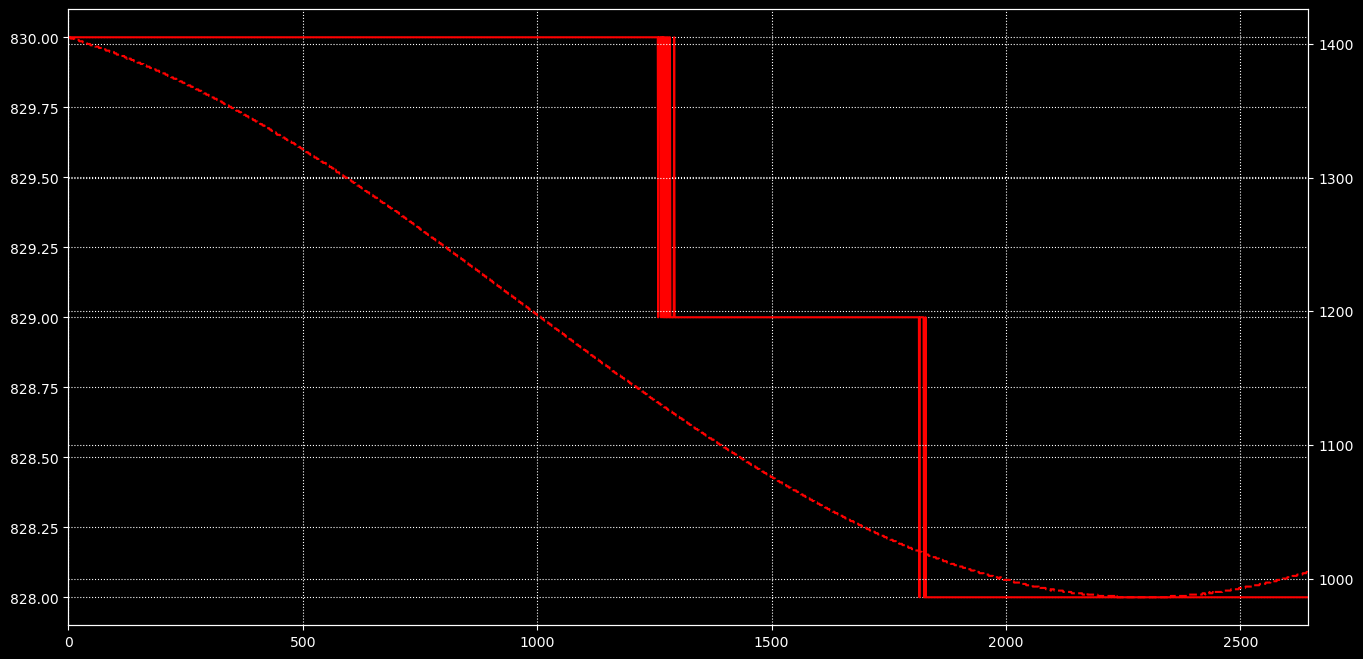

In [7]:
plotData(results[:,0].cpu().numpy(), dataYR=results[:,1].cpu().numpy())


## Analyze

[-0.06289792  0.5580461   1.3958115   0.64101678]
[0.13432025 0.52185914 1.00248687 1.98480588]
[0.43991047 0.44208335 0.06673105 4.52910447]


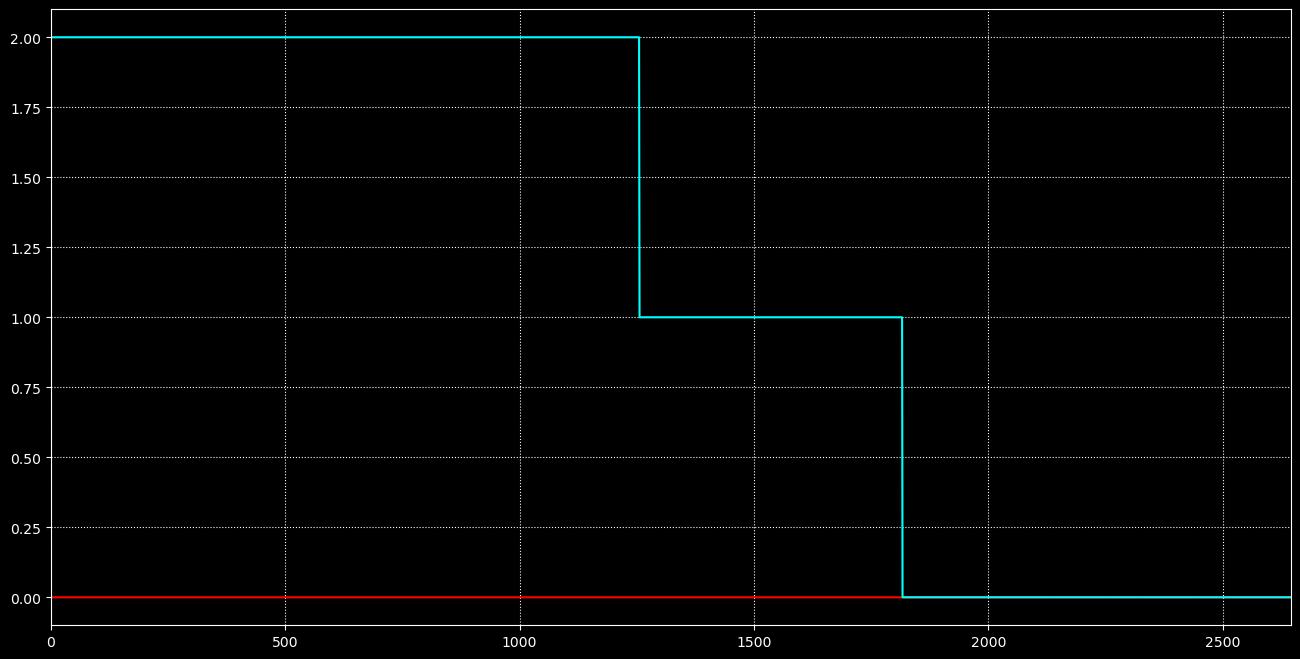

In [8]:
def sin_func(x, a, b, c, d):
    return a + b * np.sin(c*x+d)

def fit_as_sin(dat) :
    delta = dat.max() - dat.min()
    if delta == 0 :
        return dat
    datS = len(dat)
    xdat = math.pi * np.linspace(0, datS-1, datS) / datS
    meanDat = dat.mean()
    dat_norm = (dat - meanDat) / delta # normalize for fitting
    popt, _ = curve_fit(sin_func, xdat, dat_norm)
    print(popt)
    dat_fit = delta * sin_func(xdat, *popt) + meanDat
    return dat_fit

yres = results[:,0].cpu().numpy()
yres_fit = fit_as_sin(yres)
#y_final = np.round(yres_fit - yres_fit.min())
y_final = np.round(yres_fit)
y_final -= y_final.min()

xres = results[:,1].cpu().numpy()
xres_fit = fit_as_sin(xres)
xshift = np.round(xres_fit - xres)
xshift_fit = fit_as_sin(xshift)
#x_final = np.round(xshift_fit - xshift_fit.min())
x_final = np.round(xshift_fit)
x_final -= x_final.min()

plotData((x_final,y_final))



## Save

In [9]:
outAr = np.stack((x_final,y_final),axis=1)
np.savetxt('test.txt', outAr)